In [10]:
from Voxel_Data_Process import *
import gzip,pickle
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt


# 定义输入的图片尺寸，图片为正方形
pixel_size = 64

# 读取实际的y_val的值的函数
def read_y_val(pixel_size, fold):
    (x_train,y_train,x_val,y_val)=load_fold_data(pixel_size,fold)
#     (x_train,y_train,x_val,y_val)=k_fold(pixel_size,fold)

    return y_val

# 测试代码
# y_val = read_y_val(pixel_size, 1)
# print('ssssssssssssssss')
# print(y_val.shape)


In [11]:
# 将y_val从[0 1]的双标签转为单标签
def convert_label(y_val):
    
    
    y_val_after = []
    y_val = list(y_val)
    
    for t in y_val:
        t = list(t)       
        if t == [1,0]:
            y_val_after.append(0)
        else:
            y_val_after.append(1)
    
    return (np.array(y_val_after))

def convert_label_pred(y_val_pred):
    # 阈值
    threshold = 0.5
    
    predicted_class = []
    
    for temp in y_val_pred:
        if temp[1] < threshold:
            predicted_class.append(0)
        else:
            predicted_class.append(1)
        
    return (np.array(predicted_class))
    
# 测试代码
# y_val = convert_label(y_val)
# print (y_val)

In [12]:
# 测试代码
# function = 'Original_CNN'
# time = 1

# 读取实验预测的y_val_pred的值,画roc时需要将概率转换为0,1标签
def read_y_val_pred(function, time, ROC):
    
    # 预测的y_val_pred, 0-4对于第几则训练
    y_val_pred = []
    
    # 判断是否含有SVM
    if ('SVM' in function):
        function1 = function[:-4]
        
        for fold in range(1,6):
            with gzip.open('../Voxel_PY/Predict/'+function1+'/'+function+'_Pred_'+str(fold)+'_'+str(time)+'.pkl','rb') as f:
                temp = pickle.load(f)
                if ROC == 0:
                    temp = convert_label_pred(temp)
                y_val_pred.append(temp)
        print ('SVM')
    else:
        for fold in range(1,6):
            with gzip.open('../Voxel_PY/Predict/'+function+'/'+function+'_Pred_'+str(fold)+'_'+str(time)+'.pkl','rb') as f:
                temp = pickle.load(f)
                print (temp.shape)
                if ROC == 0:
                    temp = convert_label_pred(temp)
                y_val_pred.append(temp)
        print ('No, SVM')
        
        
    return y_val_pred



In [3]:
# 获取实际的y_val
y_val = []
for fold in range(1, 6):
    temp = read_y_val(pixel_size, fold)
    temp = convert_label(temp)
    y_val.append(temp)

Data load success....
Data load success....
Data load success....
Data load success....
Data load success....


In [ ]:
# 测试代码

y_origin = []
for fold in range(1, 6):
    temp = read_y_val(pixel_size, fold) 
#     temp= convert_label(temp)
    y_origin.append(temp)
    
function = 'Single_Dilation_Conv'
# function = 'Single_View'

time = 0
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

y_pred = read_y_val_pred(function, time,0)

for fold in range(0, 5):
    fpr, tpr, thresholds = roc_curve(y_origin[fold].ravel(), y_pred[fold].ravel())
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr,
#         label='ROC fold %d (area = %0.4f)' % (fold, roc_auc))

# 计算fpr, tpr平均值
mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, linestyle='--',
    label=function+' (AUC = %0.4f)' % mean_auc)
lw = 2
# 画ROC曲线
plt.grid(True)
plt.plot([0,0.5],[0,1], linestyle='--', lw=lw)
plt.xlim([0,0.5])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#     plt.savefig('/home/ilab/Jupyter/CNN/Voxel_PY/Result/Result.png')
plt.show()

In [4]:
# 求 Accuracy, Recall, sensitivity and specificity 
def ARSS(function, time):
    
    # 下标0-4对于第几则训练，5为平均值
    accuracy = []
    sensitivity = []
    specificity = []
    recall = []
    # 预测的y_val_pred
    y_val_pred = read_y_val_pred(function, time, 0)
    
        
    # 初始化 False Positive Rate和True Positive Rate
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold in range(0, 5):
        
        
        cm1 = confusion_matrix(y_val[fold], y_val_pred[fold])
        total1=sum(sum(cm1))
        
        # 计算recall        
        recall1 = recall_score(y_val[fold], y_val_pred[fold], average='weighted')
        recall.append(recall1)
        #####from confusion matrix calculate accuracy
        accuracy1=float((cm1[0,0]+cm1[1,1]))/float(total1)
        accuracy.append(accuracy1)
         
        sensitivity1 = float(cm1[0,0])/float((cm1[0,0]+cm1[0,1]))
        sensitivity.append(sensitivity1)
        
        specificity1 = float(cm1[1,1])/float((cm1[1,0]+cm1[1,1]))
        specificity.append(specificity1)
        

    # 计算平均值
    accuracy_mean = (accuracy[0]+accuracy[1]+accuracy[2]+accuracy[3]+accuracy[4])/5
    sensitivity_mean = (sensitivity[0]+sensitivity[1]+sensitivity[2]+sensitivity[3]+sensitivity[4])/5
    specificity_mean = (specificity[0]+specificity[1]+specificity[2]+specificity[3]+specificity[4])/5
    recall_mean = (recall[0]+recall[1]+recall[2]+recall[3]+recall[4])/5
    accuracy.append(accuracy_mean)
    sensitivity.append(sensitivity_mean)
    specificity.append(specificity_mean)
    recall.append(recall_mean)
    
    
    print ('======== '+function+' ========')
    print ('Accuracy : '+str(accuracy[5]))
    print ('Sensitivity : '+str(sensitivity[5]))
    print ('Specificity : '+str(specificity[5]))
    print ('Recall : '+str(recall[5]))
    
    
    f = open('/home/ilab/Jupyter/CNN/Voxel_PY/Result/'+function+'.txt','w')
    f.write('======== '+function+' ========')
    f.write('\n')
    f.write('Accuracy : '+str(accuracy[5])+'\n')
    f.write('Sensitivity : '+str(sensitivity[5])+'\n')
    f.write('Specificity : '+str(specificity[5])+'\n')
    f.write('Recall : '+str(recall[5])+'\n')
    
    f.close()
       

In [8]:
# ARSS('ABM', 1)
# ARSS('ABM_SVM', 0)
# ARSS('MCrop_SVM', 1)
# ARSS('Original_CNN', 0)
# ARSS('Single_Dilation', 2)
# ARSS('Single_Resnet', 0)
# ARSS('9_Planes', 0)

# ARSS('Single_Dilation_Conv', 0)
# ARSS('Single_View', 0)
# ARSS('Original_CNN',0)

# ARSS('Single_Dilation_Conv', 0)

# # draw_ROC('Single_Dilation_Conv', 3,'pink','Ours')

# ARSS('Single_Dilation_3_Conv', 4)
# ARSS('Single_Dilation_1_Conv', 4)

# ARSS('Single_Dilation_2_Conv', 4)


# ARSS('Single_View', 0)
ARSS('Single_View', 4)

# draw_ROC('Single_Resnet_View', 4,'orange','2D Resnet')

# draw_ROC('Orginal_CNN_1')
# draw_ROC('Single_Dilation_Conv')

(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
======== Single_View ========
Accuracy : 0.859154929577
Sensitivity : 0.871428571429
Specificity : 0.847222222222
Recall : 0.859154929577


In [13]:
y_origin = []
for fold in range(1, 6):
    temp = read_y_val(pixel_size, fold)    
    temp= convert_label(temp)
    y_origin.append(temp)

Data load success....
Data load success....
Data load success....
Data load success....
Data load success....


In [54]:
# y_pred = read_y_val_pred('Original_CNN',2, 0)
y_pred = read_y_val_pred('Single_Dilation_Conv', 0, 0)

print (len(y_pred))


(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
5


In [14]:
def draw_ROC(function, time,line_color,pic_name):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    y_pred = read_y_val_pred(function, time, 0)
    for fold in range(0, 5):
        fpr, tpr, thresholds = roc_curve(y_origin[fold].ravel(), y_pred[fold].ravel())
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
    # 计算fpr, tpr平均值
    mean_tpr /= 5
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, linestyle='--',
        label=pic_name+' (AUC = %0.3f)' % mean_auc,lw=2,color=line_color)
    
#     f = open('/home/ilab/Jupyter/CNN/Voxel_PY/Result/'+function+'.txt','a')
#     f.write('AUC : '+str(mean_auc)+'\n')
#     f.close()

In [6]:
draw_ROC('Single_View', 0,'red','Single_View')
# draw_ROC('ABM_SVM', 0)
# draw_ROC('MCrop_SVM', 1)
# draw_ROC('Original_CNN', 0)
# draw_ROC('Single_Dilation', 2)
# draw_ROC('Single_Resnet', 0)
draw_ROC('Single_Dilation_Conv', 0,'green','Single_Dilation_Conv')
# draw_ROC('Original_CNN', 0,'orange','3D CNN [4]')


(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM


(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM
(142, 2)
(142, 2)
(142, 2)
(142, 2)
(142, 2)
No, SVM


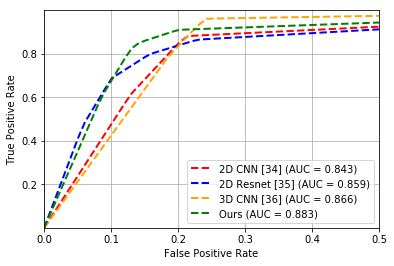

In [15]:
draw_ROC('Single_View', 0,'red','2D CNN [34]')
draw_ROC('Single_View', 4,'blue','2D Resnet [35]')

# draw_ROC('Single_Resnet_View', 4,'orange','2D Resnet')

draw_ROC('Orginal_CNN_1', 4,'orange','3D CNN [36]')
draw_ROC('Single_Dilation_Conv', 0,'green','Ours')


# draw_ROC('Single_Dilation_Conv', 0,'black','Ours')
# draw_ROC('Single_Dilation_Conv', 0,'red','Dilation-4')

# draw_ROC('Single_Dilation_Conv', 3,'pink','Ours')

# draw_ROC('Single_Dilation_3_Conv', 4,'blue','Dilation-1')
# draw_ROC('Single_Dilation_1_Conv', 4,'green','Dilation-2')

# draw_ROC('Single_Dilation_2_Conv', 4,'black','Dilation-3')

# draw_ROC('Single_Dilation_4_Conv', 4,'red','Dilation-4')


lw = 2
# 画ROC曲线
plt.grid(True)
# plt.plot([0,0.5],[0,1], linestyle='--',color='black')
xlim=np.arange(0,0.6,0.1)
ylim=np.arange(0.2,1,0.2)

# plt.xticks.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(xlim)
plt.yticks(ylim)

plt.xlim([0,0.5])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.savefig('/home/ilab/Jupyter/CNN/Voxel_PY/Result/Result_1.png',figsize=(50, 50), dpi=400)
plt.savefig('/home/ilab/Jupyter/CNN/Voxel_PY/Result/Common_Result.png',figsize=(50, 50), dpi=400)

plt.show()